In [18]:
import numpy as np
import torch

from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]
    
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False)

Files already downloaded and verified


torch.Size([128, 3, 32, 32]) torch.Size([128])


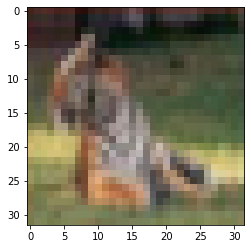

In [20]:
for img, label in valid_loader:
    print(img.shape, label.shape)
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.2)
        self.dp_four = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 150)
        self.out = torch.nn.Linear(150, 100)
        
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net()
net.to(device)
print(net)

Net(
  (dp_three): Dropout(p=0.2, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=150, bias=True)
  (out): Linear(in_features=150, out_features=100, bias=True)
)


In [13]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()

In [6]:
from time import time
from tqdm import tqdm


def train(model,
          criterion,
          optimizer,
          train_dataloader,
          test_dataloader,
          print_every,
          num_epoch):
    steps = 0
    train_losses, val_losses = [], []

    model.to(device)
    for epoch in tqdm(range(num_epoch)):
        running_loss = 0
        correct_train = 0
        total_train = 0
        start_time = time()
        iter_time = time()
        
        model.train()
        for i, (images, labels) in enumerate(train_dataloader):
            steps += 1
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(images)
            loss = criterion(output, labels)

            correct_train += (torch.max(output, dim=1)[1] == labels).sum()
            total_train += labels.size(0)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Logging
            if steps % print_every == 0:
                print(f'Epoch [{epoch + 1}]/[{num_epoch}]. Batch [{i + 1}]/[{len(train_dataloader)}].', end=' ')
                print(f'Train loss {running_loss / steps:.3f}.', end=' ')
                print(f'Train acc {correct_train / total_train * 100:.3f}.', end=' ')
                with torch.no_grad():
                    model.eval()
                    correct_val, total_val = 0, 0
                    val_loss = 0
                    for images, labels in test_dataloader:
                        images = images.to(device)
                        labels = labels.to(device)
                        output = model(images)
                        loss = criterion(output, labels)
                        val_loss += loss.item()

                        correct_val += (torch.max(output, dim=1)[1] == labels).sum()
                        total_val += labels.size(0)

                print(f'Val loss {val_loss / len(test_dataloader):.3f}. Val acc {correct_val / total_val * 100:.3f}.', end=' ')
                print(f'Took {time() - iter_time:.3f} seconds')
                iter_time = time()

                train_losses.append(running_loss / total_train)
                val_losses.append(val_loss / total_val)


        print(f'Epoch took {time() - start_time}') 
        torch.save(model, f'checkpoint_{correct_val / total_val * 100:.2f}')
        
    return model, train_losses, val_losses

In [15]:
print_every = 50
num_epoch = 20

net, train_losses, val_losses = train(
    model=net,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch [1]/[20]. Batch [50]/[372]. Train loss 3.715. Train acc 13.469. Val loss 3.825. Val acc 11.120. Took 2.267 seconds
Epoch [1]/[20]. Batch [100]/[372]. Train loss 3.638. Train acc 14.375. Val loss 3.978. Val acc 11.040. Took 1.732 seconds
Epoch [1]/[20]. Batch [150]/[372]. Train loss 3.589. Train acc 15.120. Val loss 3.905. Val acc 12.000. Took 1.714 seconds
Epoch [1]/[20]. Batch [200]/[372]. Train loss 3.555. Train acc 15.773. Val loss 3.952. Val acc 13.160. Took 1.708 seconds
Epoch [1]/[20]. Batch [250]/[372]. Train loss 3.535. Train acc 16.044. Val loss 3.991. Val acc 11.800. Took 1.692 seconds
Epoch [1]/[20]. Batch [300]/[372]. Train loss 3.514. Train acc 16.266. Val loss 3.811. Val acc 13.800. Took 1.704 seconds
Epoch [1]/[20]. Batch [350]/[372]. Train loss 3.501. Train acc 16.429. Val loss 3.837. Val acc 14.400. Took 1.676 seconds


  5%|████▏                                                                              | 1/20 [00:13<04:09, 13.12s/it]

Epoch took 13.114597797393799
Epoch [2]/[20]. Batch [28]/[372]. Train loss 0.248. Train acc 15.402. Val loss 3.875. Val acc 11.640. Took 1.073 seconds
Epoch [2]/[20]. Batch [78]/[372]. Train loss 0.600. Train acc 16.967. Val loss 3.747. Val acc 15.520. Took 1.700 seconds
Epoch [2]/[20]. Batch [128]/[372]. Train loss 0.877. Train acc 17.639. Val loss 3.942. Val acc 13.000. Took 1.661 seconds
Epoch [2]/[20]. Batch [178]/[372]. Train loss 1.099. Train acc 17.903. Val loss 3.797. Val acc 14.800. Took 1.697 seconds
Epoch [2]/[20]. Batch [228]/[372]. Train loss 1.286. Train acc 18.233. Val loss 3.947. Val acc 13.080. Took 1.705 seconds
Epoch [2]/[20]. Batch [278]/[372]. Train loss 1.442. Train acc 18.581. Val loss 3.972. Val acc 13.480. Took 1.701 seconds
Epoch [2]/[20]. Batch [328]/[372]. Train loss 1.577. Train acc 18.781. Val loss 3.760. Val acc 15.360. Took 1.693 seconds


 10%|████████▎                                                                          | 2/20 [00:25<03:49, 12.77s/it]

Epoch took 12.514762878417969
Epoch [3]/[20]. Batch [6]/[372]. Train loss 0.028. Train acc 16.406. Val loss 3.874. Val acc 12.960. Took 0.431 seconds
Epoch [3]/[20]. Batch [56]/[372]. Train loss 0.233. Train acc 20.006. Val loss 3.957. Val acc 13.840. Took 1.708 seconds
Epoch [3]/[20]. Batch [106]/[372]. Train loss 0.411. Train acc 20.276. Val loss 4.120. Val acc 13.360. Took 1.700 seconds
Epoch [3]/[20]. Batch [156]/[372]. Train loss 0.568. Train acc 20.653. Val loss 3.845. Val acc 15.760. Took 1.682 seconds
Epoch [3]/[20]. Batch [206]/[372]. Train loss 0.709. Train acc 20.589. Val loss 3.864. Val acc 14.200. Took 1.685 seconds
Epoch [3]/[20]. Batch [256]/[372]. Train loss 0.834. Train acc 20.868. Val loss 3.897. Val acc 14.800. Took 1.686 seconds
Epoch [3]/[20]. Batch [306]/[372]. Train loss 0.947. Train acc 20.946. Val loss 3.959. Val acc 14.640. Took 1.690 seconds
Epoch [3]/[20]. Batch [356]/[372]. Train loss 1.050. Train acc 20.962. Val loss 3.748. Val acc 15.960. Took 1.680 secon

 15%|████████████▍                                                                      | 3/20 [00:38<03:36, 12.74s/it]

Epoch took 12.703525304794312
Epoch [4]/[20]. Batch [34]/[372]. Train loss 0.101. Train acc 16.820. Val loss 3.625. Val acc 16.480. Took 1.235 seconds
Epoch [4]/[20]. Batch [84]/[372]. Train loss 0.229. Train acc 20.406. Val loss 3.867. Val acc 14.640. Took 1.663 seconds
Epoch [4]/[20]. Batch [134]/[372]. Train loss 0.347. Train acc 21.269. Val loss 3.746. Val acc 16.520. Took 1.681 seconds
Epoch [4]/[20]. Batch [184]/[372]. Train loss 0.455. Train acc 21.837. Val loss 3.700. Val acc 16.800. Took 1.671 seconds
Epoch [4]/[20]. Batch [234]/[372]. Train loss 0.555. Train acc 21.945. Val loss 3.778. Val acc 16.480. Took 1.680 seconds
Epoch [4]/[20]. Batch [284]/[372]. Train loss 0.647. Train acc 22.092. Val loss 3.666. Val acc 17.760. Took 1.720 seconds
Epoch [4]/[20]. Batch [334]/[372]. Train loss 0.732. Train acc 22.305. Val loss 3.695. Val acc 17.320. Took 1.698 seconds


 20%|████████████████▌                                                                  | 4/20 [00:50<03:22, 12.63s/it]

Epoch took 12.443170547485352
Epoch [5]/[20]. Batch [12]/[372]. Train loss 0.027. Train acc 17.643. Val loss 3.708. Val acc 15.120. Took 0.602 seconds
Epoch [5]/[20]. Batch [62]/[372]. Train loss 0.127. Train acc 21.837. Val loss 3.780. Val acc 16.720. Took 1.712 seconds
Epoch [5]/[20]. Batch [112]/[372]. Train loss 0.220. Train acc 23.110. Val loss 3.609. Val acc 18.800. Took 1.692 seconds
Epoch [5]/[20]. Batch [162]/[372]. Train loss 0.307. Train acc 23.659. Val loss 3.614. Val acc 17.840. Took 1.707 seconds
Epoch [5]/[20]. Batch [212]/[372]. Train loss 0.388. Train acc 23.692. Val loss 3.562. Val acc 19.480. Took 1.704 seconds
Epoch [5]/[20]. Batch [262]/[372]. Train loss 0.464. Train acc 23.906. Val loss 3.764. Val acc 16.680. Took 1.694 seconds
Epoch [5]/[20]. Batch [312]/[372]. Train loss 0.537. Train acc 23.908. Val loss 3.735. Val acc 16.800. Took 1.727 seconds
Epoch [5]/[20]. Batch [362]/[372]. Train loss 0.605. Train acc 24.007. Val loss 3.750. Val acc 17.760. Took 1.684 seco

 25%|████████████████████▊                                                              | 5/20 [01:03<03:10, 12.69s/it]

Epoch took 12.79625415802002
Epoch [6]/[20]. Batch [40]/[372]. Train loss 0.068. Train acc 20.039. Val loss 3.611. Val acc 17.360. Took 1.456 seconds
Epoch [6]/[20]. Batch [90]/[372]. Train loss 0.145. Train acc 22.309. Val loss 3.865. Val acc 16.200. Took 1.711 seconds
Epoch [6]/[20]. Batch [140]/[372]. Train loss 0.217. Train acc 23.449. Val loss 3.678. Val acc 18.240. Took 1.704 seconds
Epoch [6]/[20]. Batch [190]/[372]. Train loss 0.285. Train acc 23.779. Val loss 3.733. Val acc 17.320. Took 1.704 seconds
Epoch [6]/[20]. Batch [240]/[372]. Train loss 0.350. Train acc 24.111. Val loss 3.730. Val acc 18.040. Took 1.712 seconds
Epoch [6]/[20]. Batch [290]/[372]. Train loss 0.412. Train acc 24.362. Val loss 3.604. Val acc 18.280. Took 1.698 seconds
Epoch [6]/[20]. Batch [340]/[372]. Train loss 0.471. Train acc 24.619. Val loss 3.590. Val acc 19.080. Took 1.689 seconds


 30%|████████████████████████▉                                                          | 6/20 [01:16<02:57, 12.65s/it]

Epoch took 12.56883716583252
Epoch [7]/[20]. Batch [18]/[372]. Train loss 0.026. Train acc 21.007. Val loss 3.675. Val acc 17.200. Took 0.790 seconds
Epoch [7]/[20]. Batch [68]/[372]. Train loss 0.090. Train acc 24.644. Val loss 3.730. Val acc 18.520. Took 1.674 seconds
Epoch [7]/[20]. Batch [118]/[372]. Train loss 0.151. Train acc 25.318. Val loss 3.587. Val acc 19.120. Took 1.685 seconds
Epoch [7]/[20]. Batch [168]/[372]. Train loss 0.210. Train acc 25.749. Val loss 3.534. Val acc 20.320. Took 1.673 seconds
Epoch [7]/[20]. Batch [218]/[372]. Train loss 0.266. Train acc 25.892. Val loss 3.542. Val acc 19.640. Took 1.707 seconds
Epoch [7]/[20]. Batch [268]/[372]. Train loss 0.319. Train acc 26.009. Val loss 3.611. Val acc 19.560. Took 1.681 seconds
Epoch [7]/[20]. Batch [318]/[372]. Train loss 0.372. Train acc 25.978. Val loss 3.649. Val acc 18.120. Took 1.700 seconds
Epoch [7]/[20]. Batch [368]/[372]. Train loss 0.422. Train acc 25.951. 

 35%|█████████████████████████████                                                      | 7/20 [01:28<02:44, 12.67s/it]

Val loss 3.722. Val acc 17.720. Took 1.683 seconds
Epoch took 12.693398714065552
Epoch [8]/[20]. Batch [46]/[372]. Train loss 0.055. Train acc 21.247. Val loss 3.574. Val acc 18.960. Took 1.614 seconds
Epoch [8]/[20]. Batch [96]/[372]. Train loss 0.109. Train acc 24.202. Val loss 3.692. Val acc 18.120. Took 1.670 seconds
Epoch [8]/[20]. Batch [146]/[372]. Train loss 0.160. Train acc 25.086. Val loss 3.845. Val acc 16.680. Took 1.687 seconds
Epoch [8]/[20]. Batch [196]/[372]. Train loss 0.210. Train acc 25.530. Val loss 3.643. Val acc 20.360. Took 1.690 seconds
Epoch [8]/[20]. Batch [246]/[372]. Train loss 0.257. Train acc 25.829. Val loss 3.559. Val acc 20.120. Took 1.587 seconds
Epoch [8]/[20]. Batch [296]/[372]. Train loss 0.303. Train acc 26.058. Val loss 3.742. Val acc 19.400. Took 1.679 seconds
Epoch [8]/[20]. Batch [346]/[372]. Train loss 0.347. Train acc 26.276. Val loss 3.727. Val acc 17.640. Took 1.699 seconds


 40%|█████████████████████████████████▏                                                 | 8/20 [01:41<02:30, 12.58s/it]

Epoch took 12.375087022781372
Epoch [9]/[20]. Batch [24]/[372]. Train loss 0.026. Train acc 21.159. Val loss 3.543. Val acc 18.360. Took 0.951 seconds
Epoch [9]/[20]. Batch [74]/[372]. Train loss 0.073. Train acc 25.739. Val loss 3.639. Val acc 18.960. Took 1.697 seconds
Epoch [9]/[20]. Batch [124]/[372]. Train loss 0.118. Train acc 26.840. Val loss 3.592. Val acc 19.960. Took 1.666 seconds
Epoch [9]/[20]. Batch [174]/[372]. Train loss 0.162. Train acc 27.056. Val loss 3.519. Val acc 19.840. Took 1.688 seconds
Epoch [9]/[20]. Batch [224]/[372]. Train loss 0.205. Train acc 27.243. Val loss 3.517. Val acc 20.280. Took 1.672 seconds
Epoch [9]/[20]. Batch [274]/[372]. Train loss 0.246. Train acc 27.341. Val loss 3.642. Val acc 18.640. Took 1.662 seconds
Epoch [9]/[20]. Batch [324]/[372]. Train loss 0.286. Train acc 27.554. Val loss 3.793. Val acc 17.840. Took 1.689 seconds


 45%|█████████████████████████████████████▎                                             | 9/20 [01:53<02:17, 12.52s/it]

Epoch took 12.400705814361572
Epoch [10]/[20]. Batch [2]/[372]. Train loss 0.002. Train acc 23.438. Val loss 3.509. Val acc 19.800. Took 0.312 seconds
Epoch [10]/[20]. Batch [52]/[372]. Train loss 0.043. Train acc 28.305. Val loss 3.647. Val acc 19.240. Took 1.663 seconds
Epoch [10]/[20]. Batch [102]/[372]. Train loss 0.084. Train acc 28.271. Val loss 3.572. Val acc 19.280. Took 1.668 seconds
Epoch [10]/[20]. Batch [152]/[372]. Train loss 0.123. Train acc 28.253. Val loss 3.750. Val acc 18.760. Took 1.680 seconds
Epoch [10]/[20]. Batch [202]/[372]. Train loss 0.162. Train acc 28.523. Val loss 3.537. Val acc 20.360. Took 1.660 seconds
Epoch [10]/[20]. Batch [252]/[372]. Train loss 0.199. Train acc 28.525. Val loss 3.599. Val acc 20.600. Took 1.676 seconds
Epoch [10]/[20]. Batch [302]/[372]. Train loss 0.236. Train acc 28.438. Val loss 3.462. Val acc 21.000. Took 1.699 seconds
Epoch [10]/[20]. Batch [352]/[372]. Train loss 0.271. Train acc 28.458. Val loss 3.602. Val acc 20.360. Took 1.6

 50%|█████████████████████████████████████████                                         | 10/20 [02:06<02:05, 12.55s/it]

Epoch took 12.59131383895874
Epoch [11]/[20]. Batch [30]/[372]. Train loss 0.025. Train acc 24.219. Val loss 3.424. Val acc 20.480. Took 1.013 seconds
Epoch [11]/[20]. Batch [80]/[372]. Train loss 0.061. Train acc 27.227. Val loss 3.475. Val acc 20.560. Took 1.588 seconds
Epoch [11]/[20]. Batch [130]/[372]. Train loss 0.097. Train acc 28.053. Val loss 3.568. Val acc 20.520. Took 1.650 seconds
Epoch [11]/[20]. Batch [180]/[372]. Train loss 0.132. Train acc 28.481. Val loss 3.451. Val acc 21.200. Took 1.726 seconds
Epoch [11]/[20]. Batch [230]/[372]. Train loss 0.166. Train acc 28.828. Val loss 3.642. Val acc 20.160. Took 2.104 seconds
Epoch [11]/[20]. Batch [280]/[372]. Train loss 0.199. Train acc 28.898. Val loss 3.518. Val acc 20.880. Took 1.803 seconds
Epoch [11]/[20]. Batch [330]/[372]. Train loss 0.231. Train acc 28.944. Val loss 3.568. Val acc 21.160. Took 1.622 seconds


 55%|█████████████████████████████████████████████                                     | 11/20 [02:18<01:53, 12.60s/it]

Epoch took 12.722126483917236
Epoch [12]/[20]. Batch [8]/[372]. Train loss 0.006. Train acc 21.484. Val loss 3.648. Val acc 20.040. Took 0.498 seconds
Epoch [12]/[20]. Batch [58]/[372]. Train loss 0.040. Train acc 28.071. Val loss 3.411. Val acc 22.280. Took 2.196 seconds
Epoch [12]/[20]. Batch [108]/[372]. Train loss 0.072. Train acc 28.805. Val loss 3.528. Val acc 21.080. Took 1.680 seconds
Epoch [12]/[20]. Batch [158]/[372]. Train loss 0.104. Train acc 29.084. Val loss 3.587. Val acc 20.560. Took 1.658 seconds
Epoch [12]/[20]. Batch [208]/[372]. Train loss 0.135. Train acc 29.380. Val loss 3.674. Val acc 19.800. Took 1.887 seconds
Epoch [12]/[20]. Batch [258]/[372]. Train loss 0.166. Train acc 29.158. Val loss 3.571. Val acc 20.440. Took 2.221 seconds
Epoch [12]/[20]. Batch [308]/[372]. Train loss 0.196. Train acc 29.414. Val loss 3.581. Val acc 20.400. Took 1.647 seconds
Epoch [12]/[20]. Batch [358]/[372]. Train loss 0.225. Train acc 29.500. Val loss 3.452. Val acc 21.680. Took 1.7

 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:32<01:44, 13.01s/it]

Epoch took 13.927712202072144
Epoch [13]/[20]. Batch [36]/[372]. Train loss 0.024. Train acc 24.023. Val loss 3.496. Val acc 20.600. Took 1.234 seconds
Epoch [13]/[20]. Batch [86]/[372]. Train loss 0.054. Train acc 27.880. Val loss 3.505. Val acc 21.240. Took 1.939 seconds
Epoch [13]/[20]. Batch [136]/[372]. Train loss 0.084. Train acc 28.952. Val loss 3.574. Val acc 20.520. Took 1.732 seconds
Epoch [13]/[20]. Batch [186]/[372]. Train loss 0.112. Train acc 29.482. Val loss 3.508. Val acc 22.160. Took 1.822 seconds
Epoch [13]/[20]. Batch [236]/[372]. Train loss 0.140. Train acc 29.860. Val loss 3.600. Val acc 20.840. Took 1.993 seconds
Epoch [13]/[20]. Batch [286]/[372]. Train loss 0.168. Train acc 29.903. Val loss 3.579. Val acc 21.000. Took 1.596 seconds
Epoch [13]/[20]. Batch [336]/[372]. Train loss 0.195. Train acc 30.025. Val loss 3.507. Val acc 21.600. Took 1.716 seconds


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:46<01:31, 13.13s/it]

Epoch took 13.39687728881836
Epoch [14]/[20]. Batch [14]/[372]. Train loss 0.009. Train acc 23.940. Val loss 3.402. Val acc 21.840. Took 0.878 seconds
Epoch [14]/[20]. Batch [64]/[372]. Train loss 0.037. Train acc 29.443. Val loss 3.573. Val acc 21.480. Took 1.785 seconds
Epoch [14]/[20]. Batch [114]/[372]. Train loss 0.064. Train acc 30.777. Val loss 3.537. Val acc 21.080. Took 1.936 seconds
Epoch [14]/[20]. Batch [164]/[372]. Train loss 0.090. Train acc 30.850. Val loss 3.625. Val acc 21.080. Took 1.923 seconds
Epoch [14]/[20]. Batch [214]/[372]. Train loss 0.116. Train acc 30.987. Val loss 3.546. Val acc 21.640. Took 1.794 seconds
Epoch [14]/[20]. Batch [264]/[372]. Train loss 0.142. Train acc 30.978. Val loss 3.614. Val acc 21.480. Took 1.832 seconds
Epoch [14]/[20]. Batch [314]/[372]. Train loss 0.167. Train acc 31.118. Val loss 3.447. Val acc 21.840. Took 1.617 seconds
Epoch [14]/[20]. Batch [364]/[372]. Train loss 0.192. Train acc 31.012. Val loss 3.492. Val acc 22.120. Took 1.7

 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [03:00<01:19, 13.32s/it]

Epoch took 13.758705854415894
Epoch [15]/[20]. Batch [42]/[372]. Train loss 0.024. Train acc 24.609. Val loss 3.423. Val acc 22.840. Took 1.966 seconds
Epoch [15]/[20]. Batch [92]/[372]. Train loss 0.050. Train acc 28.227. Val loss 3.515. Val acc 21.760. Took 1.656 seconds
Epoch [15]/[20]. Batch [142]/[372]. Train loss 0.075. Train acc 29.209. Val loss 3.516. Val acc 21.760. Took 1.870 seconds
Epoch [15]/[20]. Batch [192]/[372]. Train loss 0.099. Train acc 29.806. Val loss 3.473. Val acc 21.280. Took 1.963 seconds
Epoch [15]/[20]. Batch [242]/[372]. Train loss 0.123. Train acc 30.136. Val loss 3.468. Val acc 22.520. Took 1.587 seconds
Epoch [15]/[20]. Batch [292]/[372]. Train loss 0.147. Train acc 30.431. Val loss 3.542. Val acc 21.440. Took 1.713 seconds
Epoch [15]/[20]. Batch [342]/[372]. Train loss 0.169. Train acc 30.766. Val loss 3.407. Val acc 22.560. Took 2.146 seconds


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:14<01:07, 13.53s/it]

Epoch took 14.005387783050537
Epoch [16]/[20]. Batch [20]/[372]. Train loss 0.011. Train acc 26.289. Val loss 3.364. Val acc 22.800. Took 0.888 seconds
Epoch [16]/[20]. Batch [70]/[372]. Train loss 0.034. Train acc 30.781. Val loss 3.544. Val acc 21.400. Took 1.584 seconds
Epoch [16]/[20]. Batch [120]/[372]. Train loss 0.058. Train acc 30.996. Val loss 3.581. Val acc 21.880. Took 1.745 seconds
Epoch [16]/[20]. Batch [170]/[372]. Train loss 0.080. Train acc 31.278. Val loss 3.545. Val acc 22.000. Took 1.564 seconds
Epoch [16]/[20]. Batch [220]/[372]. Train loss 0.103. Train acc 31.506. Val loss 3.569. Val acc 21.560. Took 1.539 seconds
Epoch [16]/[20]. Batch [270]/[372]. Train loss 0.125. Train acc 31.531. Val loss 3.385. Val acc 23.360. Took 1.553 seconds
Epoch [16]/[20]. Batch [320]/[372]. Train loss 0.146. Train acc 31.528. Val loss 3.391. Val acc 23.720. Took 1.662 seconds
Epoch [16]/[20]. Batch [370]/[372]. Train loss 0.168. Train acc 31.666. 

 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:26<00:52, 13.18s/it]

Val loss 3.508. Val acc 21.920. Took 1.794 seconds
Epoch took 12.380369663238525
Epoch [17]/[20]. Batch [48]/[372]. Train loss 0.024. Train acc 25.244. Val loss 3.407. Val acc 22.880. Took 1.923 seconds
Epoch [17]/[20]. Batch [98]/[372]. Train loss 0.046. Train acc 28.898. Val loss 3.483. Val acc 22.640. Took 1.879 seconds
Epoch [17]/[20]. Batch [148]/[372]. Train loss 0.067. Train acc 29.920. Val loss 3.501. Val acc 21.200. Took 1.858 seconds
Epoch [17]/[20]. Batch [198]/[372]. Train loss 0.088. Train acc 30.658. Val loss 3.551. Val acc 21.640. Took 1.596 seconds
Epoch [17]/[20]. Batch [248]/[372]. Train loss 0.109. Train acc 31.020. Val loss 3.581. Val acc 22.240. Took 1.713 seconds
Epoch [17]/[20]. Batch [298]/[372]. Train loss 0.129. Train acc 31.221. Val loss 3.483. Val acc 23.520. Took 2.155 seconds
Epoch [17]/[20]. Batch [348]/[372]. Train loss 0.150. Train acc 31.391. Val loss 3.539. Val acc 22.240. Took 1.853 seconds


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:40<00:39, 13.31s/it]

Epoch took 13.602864980697632
Epoch [18]/[20]. Batch [26]/[372]. Train loss 0.012. Train acc 26.142. Val loss 3.444. Val acc 23.600. Took 0.993 seconds
Epoch [18]/[20]. Batch [76]/[372]. Train loss 0.033. Train acc 30.479. Val loss 3.440. Val acc 23.560. Took 1.729 seconds
Epoch [18]/[20]. Batch [126]/[372]. Train loss 0.053. Train acc 31.517. Val loss 3.468. Val acc 23.080. Took 2.195 seconds
Epoch [18]/[20]. Batch [176]/[372]. Train loss 0.073. Train acc 31.836. Val loss 3.455. Val acc 23.200. Took 1.883 seconds
Epoch [18]/[20]. Batch [226]/[372]. Train loss 0.092. Train acc 32.128. Val loss 3.585. Val acc 22.160. Took 1.746 seconds
Epoch [18]/[20]. Batch [276]/[372]. Train loss 0.112. Train acc 32.195. Val loss 3.554. Val acc 22.040. Took 1.614 seconds
Epoch [18]/[20]. Batch [326]/[372]. Train loss 0.131. Train acc 32.309. Val loss 3.388. Val acc 23.920. Took 1.518 seconds


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:52<00:26, 13.18s/it]

Epoch took 12.863946914672852
Epoch [19]/[20]. Batch [4]/[372]. Train loss 0.002. Train acc 25.000. Val loss 3.570. Val acc 21.720. Took 0.323 seconds
Epoch [19]/[20]. Batch [54]/[372]. Train loss 0.021. Train acc 32.812. Val loss 3.581. Val acc 22.760. Took 1.661 seconds
Epoch [19]/[20]. Batch [104]/[372]. Train loss 0.040. Train acc 32.685. Val loss 3.575. Val acc 22.840. Took 1.530 seconds
Epoch [19]/[20]. Batch [154]/[372]. Train loss 0.059. Train acc 33.005. Val loss 3.420. Val acc 23.440. Took 1.502 seconds
Epoch [19]/[20]. Batch [204]/[372]. Train loss 0.078. Train acc 32.904. Val loss 3.445. Val acc 23.160. Took 1.580 seconds
Epoch [19]/[20]. Batch [254]/[372]. Train loss 0.096. Train acc 33.092. Val loss 3.425. Val acc 22.800. Took 1.748 seconds
Epoch [19]/[20]. Batch [304]/[372]. Train loss 0.114. Train acc 33.262. Val loss 3.423. Val acc 22.800. Took 2.242 seconds
Epoch [19]/[20]. Batch [354]/[372]. Train loss 0.132. Train acc 33.249. Val loss 3.506. Val acc 23.520. Took 1.6

 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [04:05<00:13, 13.04s/it]

Epoch took 12.725600719451904
Epoch [20]/[20]. Batch [32]/[372]. Train loss 0.013. Train acc 25.342. Val loss 3.349. Val acc 23.200. Took 1.175 seconds
Epoch [20]/[20]. Batch [82]/[372]. Train loss 0.032. Train acc 29.964. Val loss 3.514. Val acc 22.440. Took 2.034 seconds
Epoch [20]/[20]. Batch [132]/[372]. Train loss 0.050. Train acc 31.581. Val loss 3.449. Val acc 23.160. Took 1.966 seconds
Epoch [20]/[20]. Batch [182]/[372]. Train loss 0.067. Train acc 32.130. Val loss 3.542. Val acc 22.400. Took 1.617 seconds
Epoch [20]/[20]. Batch [232]/[372]. Train loss 0.085. Train acc 32.371. Val loss 3.440. Val acc 24.240. Took 1.752 seconds
Epoch [20]/[20]. Batch [282]/[372]. Train loss 0.102. Train acc 32.635. Val loss 3.373. Val acc 24.400. Took 1.971 seconds
Epoch [20]/[20]. Batch [332]/[372]. Train loss 0.119. Train acc 32.782. Val loss 3.457. Val acc 23.680. Took 1.752 seconds


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:19<00:00, 12.96s/it]

Epoch took 13.463210821151733


In [21]:
from torchvision import models

In [22]:
resnet50 = models.resnet50(pretrained=True)

C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\user/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [23]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [24]:
set_parameter_requires_grad(resnet50, True)

In [25]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [26]:
resnet50.fc = nn.Linear(2048, 100)

### Проверить на valid_transform размерность входящ картинки (какой размер должен быть на imagenet)

In [31]:
trans_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 224, 224]) torch.Size([128])


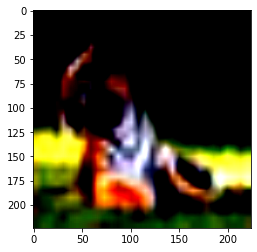

In [33]:
for img, label in valid_loader:
    print(img.shape, label.shape)
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [35]:
params_to_update = []
for name,param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.0003)
criterion = nn.CrossEntropyLoss()

In [36]:
print_every = 50
num_epoch = 20

resnet50, train_losses, val_losses = train(
    model=resnet50,
    criterion=criterion,
    optimizer=optimizer,
    train_dataloader=train_loader,
    test_dataloader=valid_loader,
    print_every=print_every,
    num_epoch=num_epoch
)

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch [1]/[20]. Batch [50]/[372]. Train loss 4.357. Train acc 7.422. Val loss 4.008. Val acc 17.720. Took 23.045 seconds
Epoch [1]/[20]. Batch [100]/[372]. Train loss 4.051. Train acc 16.523. Val loss 3.451. Val acc 34.760. Took 30.511 seconds
Epoch [1]/[20]. Batch [150]/[372]. Train loss 3.798. Train acc 22.828. Val loss 3.065. Val acc 39.240. Took 37.483 seconds
Epoch [1]/[20]. Batch [200]/[372]. Train loss 3.586. Train acc 27.457. Val loss 2.775. Val acc 43.360. Took 35.705 seconds
Epoch [1]/[20]. Batch [250]/[372]. Train loss 3.413. Train acc 30.613. Val loss 2.550. Val acc 46.400. Took 36.237 seconds
Epoch [1]/[20]. Batch [300]/[372]. Train loss 3.269. Train acc 33.151. Val loss 2.399. Val acc 47.080. Took 36.560 seconds
Epoch [1]/[20]. Batch [350]/[372]. Train loss 3.141. Train acc 35.335. Val loss 2.260. Val acc 49.280. Took 37.445 seconds


  5%|████                                                                            | 1/20 [04:08<1:18:46, 248.74s/it]

Epoch took 248.5873737335205
Epoch [2]/[20]. Batch [28]/[372]. Train loss 0.160. Train acc 48.633. Val loss 2.200. Val acc 48.040. Took 26.900 seconds
Epoch [2]/[20]. Batch [78]/[372]. Train loss 0.383. Train acc 49.649. Val loss 2.118. Val acc 51.040. Took 37.668 seconds
Epoch [2]/[20]. Batch [128]/[372]. Train loss 0.552. Train acc 50.653. Val loss 2.052. Val acc 50.360. Took 38.180 seconds
Epoch [2]/[20]. Batch [178]/[372]. Train loss 0.689. Train acc 50.812. Val loss 1.997. Val acc 50.440. Took 38.244 seconds
Epoch [2]/[20]. Batch [228]/[372]. Train loss 0.799. Train acc 50.953. Val loss 1.951. Val acc 51.520. Took 38.138 seconds
Epoch [2]/[20]. Batch [278]/[372]. Train loss 0.887. Train acc 51.231. Val loss 1.911. Val acc 51.080. Took 37.647 seconds
Epoch [2]/[20]. Batch [328]/[372]. Train loss 0.960. Train acc 51.465. Val loss 1.880. Val acc 52.000. Took 37.521 seconds


 10%|████████                                                                        | 2/20 [08:47<1:19:50, 266.15s/it]

Epoch took 278.1723163127899
Epoch [3]/[20]. Batch [6]/[372]. Train loss 0.015. Train acc 53.125. Val loss 1.886. Val acc 51.160. Took 13.990 seconds
Epoch [3]/[20]. Batch [56]/[372]. Train loss 0.130. Train acc 53.962. Val loss 1.812. Val acc 52.720. Took 37.137 seconds
Epoch [3]/[20]. Batch [106]/[372]. Train loss 0.227. Train acc 54.621. Val loss 1.800. Val acc 52.920. Took 37.649 seconds
Epoch [3]/[20]. Batch [156]/[372]. Train loss 0.314. Train acc 54.677. Val loss 1.776. Val acc 53.200. Took 37.127 seconds
Epoch [3]/[20]. Batch [206]/[372]. Train loss 0.391. Train acc 54.547. Val loss 1.755. Val acc 53.680. Took 37.938 seconds
Epoch [3]/[20]. Batch [256]/[372]. Train loss 0.459. Train acc 54.822. Val loss 1.722. Val acc 54.640. Took 37.510 seconds
Epoch [3]/[20]. Batch [306]/[372]. Train loss 0.519. Train acc 55.060. Val loss 1.737. Val acc 53.680. Took 37.545 seconds
Epoch [3]/[20]. Batch [356]/[372]. Train loss 0.573. Train acc 55.098. Val loss 1.714. Val acc 54.520. Took 37.98

 15%|████████████                                                                    | 3/20 [13:32<1:17:51, 274.80s/it]

Epoch took 284.9238338470459
Epoch [4]/[20]. Batch [34]/[372]. Train loss 0.051. Train acc 55.653. Val loss 1.697. Val acc 55.600. Took 30.125 seconds
Epoch [4]/[20]. Batch [84]/[372]. Train loss 0.118. Train acc 56.631. Val loss 1.686. Val acc 54.960. Took 37.850 seconds
Epoch [4]/[20]. Batch [134]/[372]. Train loss 0.179. Train acc 56.681. Val loss 1.676. Val acc 54.400. Took 37.931 seconds
Epoch [4]/[20]. Batch [184]/[372]. Train loss 0.236. Train acc 56.709. Val loss 1.676. Val acc 54.880. Took 37.233 seconds
Epoch [4]/[20]. Batch [234]/[372]. Train loss 0.286. Train acc 56.684. Val loss 1.638. Val acc 56.400. Took 37.682 seconds
Epoch [4]/[20]. Batch [284]/[372]. Train loss 0.336. Train acc 56.646. Val loss 1.643. Val acc 56.080. Took 37.621 seconds
Epoch [4]/[20]. Batch [334]/[372]. Train loss 0.379. Train acc 56.730. Val loss 1.638. Val acc 55.600. Took 37.755 seconds


 20%|████████████████                                                                | 4/20 [18:08<1:13:29, 275.57s/it]

Epoch took 276.60043382644653
Epoch [5]/[20]. Batch [12]/[372]. Train loss 0.013. Train acc 56.576. Val loss 1.634. Val acc 55.600. Took 17.400 seconds
Epoch [5]/[20]. Batch [62]/[372]. Train loss 0.062. Train acc 58.354. Val loss 1.619. Val acc 56.120. Took 37.951 seconds
Epoch [5]/[20]. Batch [112]/[372]. Train loss 0.110. Train acc 58.085. Val loss 1.611. Val acc 57.120. Took 37.802 seconds
Epoch [5]/[20]. Batch [162]/[372]. Train loss 0.154. Train acc 58.049. Val loss 1.606. Val acc 56.720. Took 37.954 seconds
Epoch [5]/[20]. Batch [212]/[372]. Train loss 0.196. Train acc 57.894. Val loss 1.598. Val acc 56.920. Took 37.422 seconds
Epoch [5]/[20]. Batch [262]/[372]. Train loss 0.236. Train acc 57.640. Val loss 1.579. Val acc 57.360. Took 36.536 seconds
Epoch [5]/[20]. Batch [312]/[372]. Train loss 0.272. Train acc 57.750. Val loss 1.586. Val acc 57.120. Took 37.959 seconds
Epoch [5]/[20]. Batch [362]/[372]. Train loss 0.306. Train acc 57.981. Val loss 1.576. Val acc 56.840. Took 38.

 25%|████████████████████                                                            | 5/20 [22:55<1:09:53, 279.60s/it]

Epoch took 286.5703213214874
Epoch [6]/[20]. Batch [40]/[372]. Train loss 0.032. Train acc 59.395. Val loss 1.581. Val acc 56.920. Took 33.756 seconds
Epoch [6]/[20]. Batch [90]/[372]. Train loss 0.071. Train acc 58.898. Val loss 1.556. Val acc 57.520. Took 37.920 seconds
Epoch [6]/[20]. Batch [140]/[372]. Train loss 0.107. Train acc 59.012. Val loss 1.568. Val acc 57.400. Took 37.893 seconds
Epoch [6]/[20]. Batch [190]/[372]. Train loss 0.141. Train acc 59.091. Val loss 1.567. Val acc 57.320. Took 37.777 seconds
Epoch [6]/[20]. Batch [240]/[372]. Train loss 0.174. Train acc 59.157. Val loss 1.563. Val acc 57.280. Took 37.504 seconds
Epoch [6]/[20]. Batch [290]/[372]. Train loss 0.205. Train acc 58.992. Val loss 1.549. Val acc 57.760. Took 36.729 seconds
Epoch [6]/[20]. Batch [340]/[372]. Train loss 0.234. Train acc 59.125. Val loss 1.555. Val acc 57.320. Took 38.036 seconds


 30%|████████████████████████                                                        | 6/20 [27:32<1:05:01, 278.70s/it]

Epoch took 276.7792329788208
Epoch [7]/[20]. Batch [18]/[372]. Train loss 0.012. Train acc 60.677. Val loss 1.527. Val acc 58.240. Took 21.037 seconds
Epoch [7]/[20]. Batch [68]/[372]. Train loss 0.044. Train acc 59.835. Val loss 1.540. Val acc 57.400. Took 38.249 seconds
Epoch [7]/[20]. Batch [118]/[372]. Train loss 0.074. Train acc 59.984. Val loss 1.542. Val acc 57.720. Took 23.231 seconds
Epoch [7]/[20]. Batch [168]/[372]. Train loss 0.104. Train acc 59.701. Val loss 1.530. Val acc 57.920. Took 22.392 seconds
Epoch [7]/[20]. Batch [218]/[372]. Train loss 0.132. Train acc 59.913. Val loss 1.534. Val acc 57.800. Took 22.399 seconds
Epoch [7]/[20]. Batch [268]/[372]. Train loss 0.159. Train acc 60.028. Val loss 1.526. Val acc 58.040. Took 22.394 seconds
Epoch [7]/[20]. Batch [318]/[372]. Train loss 0.184. Train acc 59.960. Val loss 1.527. Val acc 58.280. Took 22.066 seconds
Epoch [7]/[20]. Batch [368]/[372]. Train loss 0.209. Train acc 59.885. Val loss 1.527. Val acc 58.280. Took 22.3

 35%|████████████████████████████▋                                                     | 7/20 [30:47<54:28, 251.43s/it]

Epoch took 195.14364051818848
Epoch [8]/[20]. Batch [46]/[372]. Train loss 0.026. Train acc 59.511. Val loss 1.550. Val acc 57.640. Took 21.493 seconds
Epoch [8]/[20]. Batch [96]/[372]. Train loss 0.052. Train acc 60.002. Val loss 1.548. Val acc 56.520. Took 22.132 seconds
Epoch [8]/[20]. Batch [146]/[372]. Train loss 0.077. Train acc 60.215. Val loss 1.530. Val acc 58.000. Took 22.119 seconds
Epoch [8]/[20]. Batch [196]/[372]. Train loss 0.102. Train acc 60.403. Val loss 1.513. Val acc 58.480. Took 22.060 seconds
Epoch [8]/[20]. Batch [246]/[372]. Train loss 0.125. Train acc 60.483. Val loss 1.519. Val acc 57.840. Took 22.149 seconds
Epoch [8]/[20]. Batch [296]/[372]. Train loss 0.148. Train acc 60.336. Val loss 1.511. Val acc 57.760. Took 22.126 seconds
Epoch [8]/[20]. Batch [346]/[372]. Train loss 0.170. Train acc 60.344. Val loss 1.505. Val acc 57.880. Took 22.105 seconds


 40%|████████████████████████████████▊                                                 | 8/20 [33:30<44:37, 223.11s/it]

Epoch took 162.3088619709015
Epoch [9]/[20]. Batch [24]/[372]. Train loss 0.012. Train acc 59.766. Val loss 1.510. Val acc 57.920. Took 16.971 seconds
Epoch [9]/[20]. Batch [74]/[372]. Train loss 0.035. Train acc 60.410. Val loss 1.496. Val acc 58.280. Took 38.349 seconds
Epoch [9]/[20]. Batch [124]/[372]. Train loss 0.057. Train acc 60.755. Val loss 1.497. Val acc 58.640. Took 37.894 seconds
Epoch [9]/[20]. Batch [174]/[372]. Train loss 0.079. Train acc 60.875. Val loss 1.495. Val acc 58.320. Took 31.876 seconds
Epoch [9]/[20]. Batch [224]/[372]. Train loss 0.100. Train acc 60.910. Val loss 1.490. Val acc 58.560. Took 30.468 seconds
Epoch [9]/[20]. Batch [274]/[372]. Train loss 0.120. Train acc 60.866. Val loss 1.490. Val acc 57.720. Took 37.720 seconds
Epoch [9]/[20]. Batch [324]/[372]. Train loss 0.140. Train acc 60.884. Val loss 1.494. Val acc 58.720. Took 37.878 seconds


 45%|████████████████████████████████████▉                                             | 9/20 [37:47<42:50, 233.64s/it]

Epoch took 256.6305937767029
Epoch [10]/[20]. Batch [2]/[372]. Train loss 0.001. Train acc 59.375. Val loss 1.516. Val acc 57.120. Took 11.501 seconds
Epoch [10]/[20]. Batch [52]/[372]. Train loss 0.021. Train acc 62.019. Val loss 1.488. Val acc 58.600. Took 38.105 seconds
Epoch [10]/[20]. Batch [102]/[372]. Train loss 0.042. Train acc 61.267. Val loss 1.491. Val acc 58.600. Took 37.870 seconds
Epoch [10]/[20]. Batch [152]/[372]. Train loss 0.061. Train acc 61.395. Val loss 1.496. Val acc 58.080. Took 36.947 seconds
Epoch [10]/[20]. Batch [202]/[372]. Train loss 0.079. Train acc 61.289. Val loss 1.494. Val acc 58.200. Took 37.498 seconds
Epoch [10]/[20]. Batch [252]/[372]. Train loss 0.098. Train acc 61.347. Val loss 1.503. Val acc 58.240. Took 37.405 seconds
Epoch [10]/[20]. Batch [302]/[372]. Train loss 0.115. Train acc 61.302. Val loss 1.487. Val acc 58.360. Took 37.391 seconds
Epoch [10]/[20]. Batch [352]/[372]. Train loss 0.133. Train acc 61.284. Val loss 1.490. Val acc 58.640. To

 50%|████████████████████████████████████████▌                                        | 10/20 [42:31<41:34, 249.44s/it]

Epoch took 284.6794662475586
Epoch [11]/[20]. Batch [30]/[372]. Train loss 0.011. Train acc 61.406. Val loss 1.467. Val acc 59.120. Took 27.591 seconds
Epoch [11]/[20]. Batch [80]/[372]. Train loss 0.029. Train acc 62.158. Val loss 1.485. Val acc 58.440. Took 37.349 seconds
Epoch [11]/[20]. Batch [130]/[372]. Train loss 0.047. Train acc 62.001. Val loss 1.483. Val acc 58.560. Took 37.682 seconds
Epoch [11]/[20]. Batch [180]/[372]. Train loss 0.064. Train acc 61.793. Val loss 1.477. Val acc 59.800. Took 37.258 seconds
Epoch [11]/[20]. Batch [230]/[372]. Train loss 0.081. Train acc 61.844. Val loss 1.466. Val acc 59.000. Took 36.524 seconds
Epoch [11]/[20]. Batch [280]/[372]. Train loss 0.097. Train acc 61.847. Val loss 1.481. Val acc 59.000. Took 35.881 seconds
Epoch [11]/[20]. Batch [330]/[372]. Train loss 0.113. Train acc 61.773. Val loss 1.452. Val acc 59.800. Took 36.661 seconds


 55%|████████████████████████████████████████████▌                                    | 11/20 [47:02<38:24, 256.02s/it]

Epoch took 270.76186537742615
Epoch [12]/[20]. Batch [8]/[372]. Train loss 0.003. Train acc 61.523. Val loss 1.476. Val acc 58.880. Took 15.080 seconds
Epoch [12]/[20]. Batch [58]/[372]. Train loss 0.019. Train acc 62.069. Val loss 1.475. Val acc 59.160. Took 37.899 seconds
Epoch [12]/[20]. Batch [108]/[372]. Train loss 0.035. Train acc 62.225. Val loss 1.448. Val acc 59.760. Took 37.711 seconds
Epoch [12]/[20]. Batch [158]/[372]. Train loss 0.051. Train acc 62.391. Val loss 1.469. Val acc 59.160. Took 37.746 seconds
Epoch [12]/[20]. Batch [208]/[372]. Train loss 0.066. Train acc 62.166. Val loss 1.481. Val acc 59.040. Took 37.213 seconds
Epoch [12]/[20]. Batch [258]/[372]. Train loss 0.080. Train acc 62.400. Val loss 1.459. Val acc 59.720. Took 29.157 seconds
Epoch [12]/[20]. Batch [308]/[372]. Train loss 0.095. Train acc 62.295. Val loss 1.453. Val acc 59.040. Took 22.134 seconds
Epoch [12]/[20]. Batch [358]/[372]. Train loss 0.109. Train acc 62.214. Val loss 1.459. Val acc 59.640. T

 60%|████████████████████████████████████████████████▌                                | 12/20 [51:06<33:37, 252.22s/it]

Epoch took 243.38985061645508
Epoch [13]/[20]. Batch [36]/[372]. Train loss 0.011. Train acc 62.869. Val loss 1.458. Val acc 59.040. Took 18.265 seconds
Epoch [13]/[20]. Batch [86]/[372]. Train loss 0.026. Train acc 62.518. Val loss 1.457. Val acc 59.640. Took 22.273 seconds
Epoch [13]/[20]. Batch [136]/[372]. Train loss 0.040. Train acc 62.224. Val loss 1.454. Val acc 59.240. Took 22.147 seconds
Epoch [13]/[20]. Batch [186]/[372]. Train loss 0.054. Train acc 62.366. Val loss 1.448. Val acc 59.800. Took 22.149 seconds
Epoch [13]/[20]. Batch [236]/[372]. Train loss 0.068. Train acc 62.609. Val loss 1.447. Val acc 59.440. Took 24.194 seconds
Epoch [13]/[20]. Batch [286]/[372]. Train loss 0.081. Train acc 62.582. Val loss 1.465. Val acc 59.480. Took 37.334 seconds
Epoch [13]/[20]. Batch [336]/[372]. Train loss 0.094. Train acc 62.616. Val loss 1.454. Val acc 59.960. Took 37.455 seconds


 65%|████████████████████████████████████████████████████▋                            | 13/20 [54:29<27:42, 237.43s/it]

Epoch took 203.23040199279785
Epoch [14]/[20]. Batch [14]/[372]. Train loss 0.004. Train acc 62.277. Val loss 1.460. Val acc 59.920. Took 18.396 seconds
Epoch [14]/[20]. Batch [64]/[372]. Train loss 0.018. Train acc 62.463. Val loss 1.435. Val acc 60.000. Took 37.621 seconds
Epoch [14]/[20]. Batch [114]/[372]. Train loss 0.031. Train acc 62.658. Val loss 1.443. Val acc 59.360. Took 37.477 seconds
Epoch [14]/[20]. Batch [164]/[372]. Train loss 0.044. Train acc 62.524. Val loss 1.470. Val acc 58.800. Took 37.492 seconds
Epoch [14]/[20]. Batch [214]/[372]. Train loss 0.057. Train acc 62.460. Val loss 1.452. Val acc 59.640. Took 37.959 seconds
Epoch [14]/[20]. Batch [264]/[372]. Train loss 0.069. Train acc 62.604. Val loss 1.456. Val acc 59.320. Took 36.804 seconds
Epoch [14]/[20]. Batch [314]/[372]. Train loss 0.082. Train acc 62.624. Val loss 1.467. Val acc 59.000. Took 29.264 seconds
Epoch [14]/[20]. Batch [364]/[372]. Train loss 0.094. Train acc 62.648. Val loss 1.469. Val acc 58.040. 

 70%|████████████████████████████████████████████████████████▋                        | 14/20 [58:49<24:24, 244.14s/it]

Epoch took 259.4802510738373
Epoch [15]/[20]. Batch [42]/[372]. Train loss 0.011. Train acc 62.965. Val loss 1.456. Val acc 59.120. Took 20.194 seconds
Epoch [15]/[20]. Batch [92]/[372]. Train loss 0.023. Train acc 62.381. Val loss 1.443. Val acc 59.720. Took 22.255 seconds
Epoch [15]/[20]. Batch [142]/[372]. Train loss 0.035. Train acc 62.731. Val loss 1.446. Val acc 59.560. Took 22.214 seconds
Epoch [15]/[20]. Batch [192]/[372]. Train loss 0.047. Train acc 62.887. Val loss 1.452. Val acc 59.560. Took 22.212 seconds
Epoch [15]/[20]. Batch [242]/[372]. Train loss 0.059. Train acc 62.987. Val loss 1.458. Val acc 59.240. Took 22.217 seconds
Epoch [15]/[20]. Batch [292]/[372]. Train loss 0.070. Train acc 62.960. Val loss 1.457. Val acc 59.160. Took 22.156 seconds
Epoch [15]/[20]. Batch [342]/[372]. Train loss 0.081. Train acc 63.003. Val loss 1.443. Val acc 59.840. Took 22.148 seconds


 75%|███████████████████████████████████████████████████████████▎                   | 15/20 [1:01:32<18:18, 219.70s/it]

Epoch took 162.90316438674927
Epoch [16]/[20]. Batch [20]/[372]. Train loss 0.005. Train acc 63.203. Val loss 1.431. Val acc 60.120. Took 12.712 seconds
Epoch [16]/[20]. Batch [70]/[372]. Train loss 0.016. Train acc 63.259. Val loss 1.441. Val acc 60.160. Took 22.214 seconds
Epoch [16]/[20]. Batch [120]/[372]. Train loss 0.028. Train acc 63.652. Val loss 1.445. Val acc 60.000. Took 22.271 seconds
Epoch [16]/[20]. Batch [170]/[372]. Train loss 0.039. Train acc 63.272. Val loss 1.468. Val acc 59.320. Took 22.313 seconds
Epoch [16]/[20]. Batch [220]/[372]. Train loss 0.050. Train acc 63.129. Val loss 1.458. Val acc 59.480. Took 22.219 seconds
Epoch [16]/[20]. Batch [270]/[372]. Train loss 0.061. Train acc 63.278. Val loss 1.459. Val acc 58.560. Took 22.144 seconds
Epoch [16]/[20]. Batch [320]/[372]. Train loss 0.071. Train acc 63.445. Val loss 1.444. Val acc 60.000. Took 22.192 seconds
Epoch [16]/[20]. Batch [370]/[372]. Train loss 0.081. Train acc 63.326. Val loss 1.426. Val acc 59.520. 

 80%|███████████████████████████████████████████████████████████████▏               | 16/20 [1:04:24<13:40, 205.23s/it]

Epoch took 171.46573066711426
Epoch [17]/[20]. Batch [48]/[372]. Train loss 0.010. Train acc 63.851. Val loss 1.440. Val acc 59.320. Took 37.823 seconds
Epoch [17]/[20]. Batch [98]/[372]. Train loss 0.021. Train acc 63.975. Val loss 1.436. Val acc 59.320. Took 37.980 seconds
Epoch [17]/[20]. Batch [148]/[372]. Train loss 0.031. Train acc 64.047. Val loss 1.422. Val acc 59.760. Took 39.703 seconds
Epoch [17]/[20]. Batch [198]/[372]. Train loss 0.042. Train acc 63.771. Val loss 1.448. Val acc 60.200. Took 40.176 seconds
Epoch [17]/[20]. Batch [248]/[372]. Train loss 0.052. Train acc 63.785. Val loss 1.450. Val acc 59.560. Took 38.783 seconds
Epoch [17]/[20]. Batch [298]/[372]. Train loss 0.062. Train acc 63.795. Val loss 1.433. Val acc 59.280. Took 38.785 seconds
Epoch [17]/[20]. Batch [348]/[372]. Train loss 0.071. Train acc 63.741. Val loss 1.444. Val acc 59.920. Took 38.093 seconds


 85%|███████████████████████████████████████████████████████████████████▏           | 17/20 [1:09:08<11:27, 229.12s/it]

Epoch took 284.5051484107971
Epoch [18]/[20]. Batch [26]/[372]. Train loss 0.005. Train acc 62.470. Val loss 1.436. Val acc 59.520. Took 27.048 seconds
Epoch [18]/[20]. Batch [76]/[372]. Train loss 0.015. Train acc 63.590. Val loss 1.427. Val acc 60.040. Took 39.831 seconds
Epoch [18]/[20]. Batch [126]/[372]. Train loss 0.025. Train acc 63.467. Val loss 1.428. Val acc 59.720. Took 39.177 seconds
Epoch [18]/[20]. Batch [176]/[372]. Train loss 0.035. Train acc 63.894. Val loss 1.435. Val acc 59.520. Took 39.719 seconds
Epoch [18]/[20]. Batch [226]/[372]. Train loss 0.045. Train acc 63.779. Val loss 1.447. Val acc 59.320. Took 39.627 seconds
Epoch [18]/[20]. Batch [276]/[372]. Train loss 0.054. Train acc 63.918. Val loss 1.445. Val acc 59.720. Took 39.987 seconds
Epoch [18]/[20]. Batch [326]/[372]. Train loss 0.063. Train acc 63.962. Val loss 1.420. Val acc 60.120. Took 39.825 seconds


 90%|███████████████████████████████████████████████████████████████████████        | 18/20 [1:14:00<08:15, 247.78s/it]

Epoch took 291.06360960006714
Epoch [19]/[20]. Batch [4]/[372]. Train loss 0.001. Train acc 65.234. Val loss 1.411. Val acc 60.000. Took 13.119 seconds
Epoch [19]/[20]. Batch [54]/[372]. Train loss 0.010. Train acc 64.337. Val loss 1.429. Val acc 59.880. Took 39.617 seconds
Epoch [19]/[20]. Batch [104]/[372]. Train loss 0.019. Train acc 64.468. Val loss 1.415. Val acc 60.000. Took 39.979 seconds
Epoch [19]/[20]. Batch [154]/[372]. Train loss 0.029. Train acc 64.291. Val loss 1.433. Val acc 59.480. Took 40.205 seconds
Epoch [19]/[20]. Batch [204]/[372]. Train loss 0.037. Train acc 64.526. Val loss 1.441. Val acc 60.040. Took 40.396 seconds
Epoch [19]/[20]. Batch [254]/[372]. Train loss 0.047. Train acc 64.216. Val loss 1.414. Val acc 59.760. Took 40.025 seconds
Epoch [19]/[20]. Batch [304]/[372]. Train loss 0.055. Train acc 64.299. Val loss 1.414. Val acc 59.600. Took 40.712 seconds
Epoch [19]/[20]. Batch [354]/[372]. Train loss 0.064. Train acc 64.283. Val loss 1.425. Val acc 59.600. T

 95%|███████████████████████████████████████████████████████████████████████████    | 19/20 [1:19:04<04:24, 264.80s/it]

Epoch took 304.26117992401123
Epoch [20]/[20]. Batch [32]/[372]. Train loss 0.006. Train acc 63.794. Val loss 1.431. Val acc 59.040. Took 31.314 seconds
Epoch [20]/[20]. Batch [82]/[372]. Train loss 0.015. Train acc 63.939. Val loss 1.436. Val acc 60.560. Took 39.712 seconds
Epoch [20]/[20]. Batch [132]/[372]. Train loss 0.023. Train acc 63.986. Val loss 1.430. Val acc 60.240. Took 39.220 seconds
Epoch [20]/[20]. Batch [182]/[372]. Train loss 0.032. Train acc 64.166. Val loss 1.416. Val acc 59.200. Took 40.628 seconds
Epoch [20]/[20]. Batch [232]/[372]. Train loss 0.040. Train acc 64.096. Val loss 1.426. Val acc 59.600. Took 39.267 seconds
Epoch [20]/[20]. Batch [282]/[372]. Train loss 0.049. Train acc 64.096. Val loss 1.424. Val acc 59.760. Took 39.629 seconds
Epoch [20]/[20]. Batch [332]/[372]. Train loss 0.057. Train acc 63.968. Val loss 1.419. Val acc 61.520. Took 39.960 seconds


100%|███████████████████████████████████████████████████████████████████████████████| 20/20 [1:23:57<00:00, 251.88s/it]

Epoch took 292.96625328063965
